# Homework 9 - Descriptive Notebook

In this homework notebook, we will create and train our own SkipGram embedding, by using the speech from Martin Luther King in the text.text file.

Get familiar with the code and write a small report (2 pages max), with answers to the questions listed at the end of the notebook.

**The report must be submitted in PDF format, before April 4th, 11.59pm!**

Do not forget to write your name and student ID on the report.

You may also submit your own copy of the notebook along with the report. If you do so, please add your name and ID to the cell below.

In [1]:
# Name: Lin Huiqing
# Student ID: 1003810

### Imports needed

Note, we strongly advise to use a CUDA/GPU machine for this notebook.

Technically, this can be done on CPU only, but it will be very slow!

If you decide to use it on CPU, you might also have to change some of the .cuda() methods used on torch tensors and models in this notebook!

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import functools
import matplotlib.pyplot as plt
CUDA = torch.cuda.is_available()
print(f"cuda is available: {CUDA}")

cuda is available: True


### Step 1. Produce some data based on a given text for training our SkipGram model    

The functions below will be used to produce our dataset for training the SkipGram model.

In [2]:
def text_to_train(text, context_window):
    """
    This function receives the text as a list of words, in lowercase format.
    It then returns data, a list of all the possible (x,y) pairs with
    - x being the middle word of the sentence of length 2*context_window+1,
    - y being a list of 2k words, containing the k preceding words and the k
    posterior words.
    """
    
    # Get data from list of words in text, using a context window of size k = context_window
    data = []
    for i in range(context_window, len(text) - context_window):
        target = [text[i+e] for e in range(-context_window, context_window+1) if i+e != i]
        input_word = text[i]
        data.append((input_word, target))
        
    return data

In [3]:
def create_text():
    """
    This function loads the string of text from the text.txt file,
    and produces a list of words in string format, as variable text.
    """
    
    # Load corpus from file
    with open("./text.txt", 'r', encoding="utf8",) as f:
        corpus = f.readlines()
    f.close()
    
    # Join corpus into a single string
    text = ""
    for s in corpus:
        l = s.split()
        for s2 in l:
            # Removes all special characters from string
            s2 = ''.join(filter(str.isalnum, s2))
            s2 += ' '
            text += s2.lower()
    text = text.split()
    
    return text

In [4]:
text = create_text()
print(text)

['i', 'am', 'happy', 'to', 'join', 'with', 'you', 'today', 'in', 'what', 'will', 'go', 'down', 'in', 'history', 'as', 'the', 'greatest', 'demonstration', 'for', 'freedom', 'in', 'the', 'history', 'of', 'our', 'nation', 'five', 'score', 'years', 'ago', 'a', 'great', 'american', 'in', 'whose', 'symbolic', 'shadow', 'we', 'stand', 'today', 'signed', 'the', 'emancipation', 'proclamation', 'this', 'momentous', 'decree', 'came', 'as', 'a', 'great', 'beacon', 'of', 'hope', 'to', 'millions', 'of', 'slaves', 'who', 'had', 'been', 'seared', 'in', 'the', 'flames', 'of', 'whithering', 'injustice', 'it', 'came', 'as', 'a', 'joyous', 'daybreak', 'to', 'end', 'the', 'long', 'night', 'of', 'their', 'captivity', 'but', 'one', 'hundred', 'years', 'later', 'the', 'colored', 'america', 'is', 'still', 'not', 'free', 'one', 'hundred', 'years', 'later', 'the', 'life', 'of', 'the', 'colored', 'american', 'is', 'still', 'sadly', 'crippled', 'by', 'the', 'manacle', 'of', 'segregation', 'and', 'the', 'chains', '

In [5]:
def generate_data(text, context_window):
    """
    This function receives the text and context window size.
    It produces four outputs:
    - vocab, a set containing the words found in text.txt,
    without any doublons,
    - word2index, a dictionary to convert words to their integer index,
    - index2word, a dictionary to convert integer index to their respective words,
    - data, containing our (x,y) pairs for training.
    """
    
    # Create vocabulary set V
    vocab = set(text)
    
    # Word to index and index 2 word converters
    word2index = {w:i for i,w in enumerate(vocab)}
    index2word = {i:w for i,w in enumerate(vocab)}
    
    # Generate data
    data = text_to_train(text, context_window)
    
    return vocab, data, word2index, index2word

In [6]:
vocab, data, word2index, index2word = generate_data(text, context_window = 2)

In [7]:
print(vocab)

{'cash', 'god', 'governor', 'was', 'engulfed', 'gentiles', 'one', 'stating', 'declaration', 'redemptive', 'valley', 'heavy', 'dignity', 'brutality', 'fatigue', 'pride', 'slaves', 'their', 'rude', 'unmindful', 'old', 'suffering', 'can', 'material', 'has', 'spot', 'he', 'louisiana', 'democracy', 'lonely', 'up', 'must', 'this', 'defaulted', 'no', 'languishing', 'lips', 'true', 'lord', 'never', 'will', 'last', 'california', 'transform', 'heat', 'captivity', 'vote', 'been', 'hampshire', 'to', 'citizen', 'now', 'sunlit', 'still', 'gain', 'am', 'us', 'creed', 'bad', 'moment', 'night', 'storms', 'opportunity', 'not', 'segregation', 'south', 'my', 'revealed', 'these', 'be', 'here', 'liberty', 'struggle', 'smaller', 'dream', 'citizenship', 'cities', 'rough', 'shadow', 'given', 'mississippi', 'proclamation', 'flesh', 'symphony', 'funds', 'speed', 'quest', 'midst', 'foundations', 'joyous', 'come', 'seared', 'together', 'plains', 'tenement', 'make', 'check', 'island', 'into', 'reality', 'interposit

In [8]:
print(word2index)

{'cash': 0, 'god': 1, 'governor': 2, 'was': 3, 'engulfed': 4, 'gentiles': 5, 'one': 6, 'stating': 7, 'declaration': 8, 'redemptive': 9, 'valley': 10, 'heavy': 11, 'dignity': 12, 'brutality': 13, 'fatigue': 14, 'pride': 15, 'slaves': 16, 'their': 17, 'rude': 18, 'unmindful': 19, 'old': 20, 'suffering': 21, 'can': 22, 'material': 23, 'has': 24, 'spot': 25, 'he': 26, 'louisiana': 27, 'democracy': 28, 'lonely': 29, 'up': 30, 'must': 31, 'this': 32, 'defaulted': 33, 'no': 34, 'languishing': 35, 'lips': 36, 'true': 37, 'lord': 38, 'never': 39, 'will': 40, 'last': 41, 'california': 42, 'transform': 43, 'heat': 44, 'captivity': 45, 'vote': 46, 'been': 47, 'hampshire': 48, 'to': 49, 'citizen': 50, 'now': 51, 'sunlit': 52, 'still': 53, 'gain': 54, 'am': 55, 'us': 56, 'creed': 57, 'bad': 58, 'moment': 59, 'night': 60, 'storms': 61, 'opportunity': 62, 'not': 63, 'segregation': 64, 'south': 65, 'my': 66, 'revealed': 67, 'these': 68, 'be': 69, 'here': 70, 'liberty': 71, 'struggle': 72, 'smaller': 73

In [9]:
print(index2word)

{0: 'cash', 1: 'god', 2: 'governor', 3: 'was', 4: 'engulfed', 5: 'gentiles', 6: 'one', 7: 'stating', 8: 'declaration', 9: 'redemptive', 10: 'valley', 11: 'heavy', 12: 'dignity', 13: 'brutality', 14: 'fatigue', 15: 'pride', 16: 'slaves', 17: 'their', 18: 'rude', 19: 'unmindful', 20: 'old', 21: 'suffering', 22: 'can', 23: 'material', 24: 'has', 25: 'spot', 26: 'he', 27: 'louisiana', 28: 'democracy', 29: 'lonely', 30: 'up', 31: 'must', 32: 'this', 33: 'defaulted', 34: 'no', 35: 'languishing', 36: 'lips', 37: 'true', 38: 'lord', 39: 'never', 40: 'will', 41: 'last', 42: 'california', 43: 'transform', 44: 'heat', 45: 'captivity', 46: 'vote', 47: 'been', 48: 'hampshire', 49: 'to', 50: 'citizen', 51: 'now', 52: 'sunlit', 53: 'still', 54: 'gain', 55: 'am', 56: 'us', 57: 'creed', 58: 'bad', 59: 'moment', 60: 'night', 61: 'storms', 62: 'opportunity', 63: 'not', 64: 'segregation', 65: 'south', 66: 'my', 67: 'revealed', 68: 'these', 69: 'be', 70: 'here', 71: 'liberty', 72: 'struggle', 73: 'smaller'

In [10]:
print(data)

[('happy', ['i', 'am', 'to', 'join']), ('to', ['am', 'happy', 'join', 'with']), ('join', ['happy', 'to', 'with', 'you']), ('with', ['to', 'join', 'you', 'today']), ('you', ['join', 'with', 'today', 'in']), ('today', ['with', 'you', 'in', 'what']), ('in', ['you', 'today', 'what', 'will']), ('what', ['today', 'in', 'will', 'go']), ('will', ['in', 'what', 'go', 'down']), ('go', ['what', 'will', 'down', 'in']), ('down', ['will', 'go', 'in', 'history']), ('in', ['go', 'down', 'history', 'as']), ('history', ['down', 'in', 'as', 'the']), ('as', ['in', 'history', 'the', 'greatest']), ('the', ['history', 'as', 'greatest', 'demonstration']), ('greatest', ['as', 'the', 'demonstration', 'for']), ('demonstration', ['the', 'greatest', 'for', 'freedom']), ('for', ['greatest', 'demonstration', 'freedom', 'in']), ('freedom', ['demonstration', 'for', 'in', 'the']), ('in', ['for', 'freedom', 'the', 'history']), ('the', ['freedom', 'in', 'history', 'of']), ('history', ['in', 'the', 'of', 'our']), ('of', [

In [11]:
def words_to_tensor(words: list, word2index: dict, dtype = torch.FloatTensor):
    """
    This fucntion converts a word or a list of words into a torch tensor,
    with appropriate format.
    It reuses the word2index dictionary.
    """
    
    tensor =  dtype([word2index[word] for word in words])
    tensor = tensor.cuda()
    
    return Variable(tensor)

### Step 2. Create a SkipGram model and train

#### Task #1: Write your own model for the SkipGram model below.

In [12]:
class SkipGram(nn.Module):
    """
    Your skipgram model here!
    """
    
    def __init__(self, context_size, embedding_dim, vocab_size):
        super(SkipGram, self).__init__()
        self.context_size = context_size

        self.emb = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, 2 * context_size * vocab_size)

    def forward(self, inputs):
        x = self.emb(inputs).view((1, -1))
        x = self.fc(x)
        log_probs = F.log_softmax(x, dim=1).view(2 * self.context_size, -1)
        return log_probs

In [13]:
# Create model and pass to CUDA
model = SkipGram(context_size = 2, embedding_dim = 20, vocab_size = len(vocab))
model = model.cuda()
model.train()

SkipGram(
  (emb): Embedding(467, 20)
  (fc): Linear(in_features=20, out_features=1868, bias=True)
)

In [14]:
# Define training parameters
learning_rate = 0.001
epochs = 50
torch.manual_seed(28)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

#### Task #2: Write your own training function for the SkipGram model in the cell below. It should return a list of losses and accuracies for display later on, along with your trained model. You may also write a helper function for computing the accuracy of your model during training.

In [15]:
def get_accuracy(model, data, word2index):
    model.eval()

    total_count = 0
    correct_count = 0
    for x, y in data:
        context_idxs = torch.tensor([word2index[x]], dtype=torch.long).cuda()
        log_probs = model(context_idxs)
        output_ids = torch.argmax(log_probs, dim=1)

        target_list = torch.tensor([word2index[w] for w in y], dtype=torch.long).cuda()

        for o_id in output_ids:
            total_count += 1
            for t_id in target_list:
                if o_id == t_id:
                    correct_count += 1
                    break
    
    return correct_count / total_count

In [16]:
def train(data, word2index, model, epochs, loss_func, optimizer):
    losses = []
    accuracies = []
    for epoch_no in range(epochs):
        model.train()

        e_loss = 0
        for x, y in data:
            # Step 1. Prepare the inputs to be passed to the model (i.e, turn 
            # the words into integer indices and wrap them in tensors)

            context_idxs = torch.tensor([word2index[x]], dtype=torch.long).cuda()

            # Step 2. Recall that torch *accumulates* gradients. Before passing 
            # in a new instance, you need to zero out the gradients from the old
            # instance
            optimizer.zero_grad()

            # Step 3. Run the forward pass, getting log probabilities over next
            # words
            log_probs = model(context_idxs)

            # Step 4. Compute your loss function. (Again, Torch wants the target
            # word wrapped in a tensor)
            target_list = torch.tensor([word2index[w] for w in y], dtype=torch.long).cuda()
            loss = loss_function(log_probs, target_list)

            # Step 5. Do the backward pass and update the gradient
            loss.backward()
            optimizer.step()

            # Get the Python number from a 1-element Tensor by calling tensor.item()
            e_loss += loss.item()
        
        model.eval()

        with torch.no_grad():
            e_loss /= len(data)
            accuracy = get_accuracy(model, data, word2index)

            print(f"Epoch {epoch_no+1}: loss - {e_loss}; accuracy - {accuracy}")

            losses.append(e_loss)
            accuracies.append(accuracy)

    return losses, accuracies, model

losses, accuracies, model = train(data, word2index, model, epochs, loss_function, optimizer)

Epoch 1: loss - 7.686139628047196; accuracy - 0.008185053380782919
Epoch 2: loss - 7.667159861771662; accuracy - 0.008540925266903915
Epoch 3: loss - 7.648266459699203; accuracy - 0.008896797153024912
Epoch 4: loss - 7.629459774112362; accuracy - 0.009608540925266904
Epoch 5: loss - 7.610741139815795; accuracy - 0.010854092526690392
Epoch 6: loss - 7.5921127343092945; accuracy - 0.019572953736654804
Epoch 7: loss - 7.573578082793972; accuracy - 0.021530249110320285
Epoch 8: loss - 7.555142109758913; accuracy - 0.03362989323843416
Epoch 9: loss - 7.536811459700832; accuracy - 0.03612099644128114
Epoch 10: loss - 7.5185947160279625; accuracy - 0.037544483985765126
Epoch 11: loss - 7.5005027275492715; accuracy - 0.04234875444839858
Epoch 12: loss - 7.482548743550039; accuracy - 0.04359430604982206
Epoch 13: loss - 7.464748233577959; accuracy - 0.045907473309608544
Epoch 14: loss - 7.447119050687743; accuracy - 0.05
Epoch 15: loss - 7.429680839212764; accuracy - 0.05604982206405694
Epoch 1

### 3. Visualization

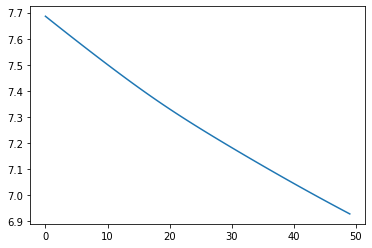

In [17]:
# Display losses over time
plt.figure()
plt.plot(losses)
plt.show()

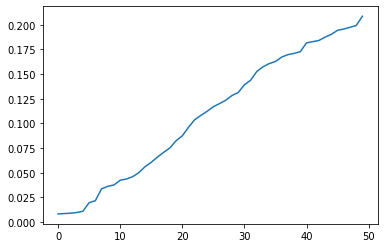

In [18]:
# Display accuracies over time
plt.figure()
plt.plot(accuracies)
plt.show()

### Questions and expected answers for the report

A. Copy and paste your SkipGram class code (Task #1 in the notebook)

B. Copy and paste your train function (Task #2 in the notebook), along with any helper functions you might have used (e.g. a function to compute the accuracy of your model after each iteration). Please also copy and paste the function call with the parameters you used for the train() function.

C. Why is the SkipGram model much more difficult to train than the CBoW. Is it problematic if it does not reach a 100% accuracy on the task it is being trained on?

D. If we were to evaluate this model by using intrinsic methods, what could be a possible approach to do so. Please submit some code that will demonstrate the performance/problems of the word embedding you have trained!

In [20]:
# save trained model
torch.save(model.state_dict(), "model.pth")

In [ ]:
# load trained model
model = SkipGram(context_size = 2, embedding_dim = 20, vocab_size = len(vocab))
model = model.cuda()
model.load_state_dict(torch.load("model.pth"))
model.eval()

In [24]:
model.state_dict()

OrderedDict([('emb.weight',
              tensor([[ 0.6692,  0.4667, -0.5606,  ...,  1.1003,  0.6653,  1.1416],
                      [ 0.6129,  1.1501,  1.1069,  ...,  0.1206,  0.3712, -0.6231],
                      [ 0.7469,  0.4312, -1.8069,  ...,  0.2078,  0.4053,  0.1399],
                      ...,
                      [ 1.7283, -0.8735,  0.0599,  ..., -0.6047, -0.3795, -1.0840],
                      [-0.5119,  1.0575,  0.1732,  ...,  0.0492,  1.7719,  0.1678],
                      [-0.7073, -0.8920,  0.4307,  ..., -0.3175,  0.2373,  0.7911]],
                     device='cuda:0')),
             ('fc.weight',
              tensor([[-0.0540, -0.0906, -0.1274,  ...,  0.1209,  0.1115,  0.0340],
                      [-0.1520,  0.0372, -0.1892,  ...,  0.0786,  0.1029,  0.1645],
                      [-0.1299, -0.1040,  0.0608,  ..., -0.0503,  0.0270,  0.1652],
                      ...,
                      [ 0.1085, -0.0765,  0.1842,  ...,  0.0393, -0.0045, -0.2343],
          

In [25]:
model.state_dict()['emb.weight']

tensor([[ 0.6692,  0.4667, -0.5606,  ...,  1.1003,  0.6653,  1.1416],
        [ 0.6129,  1.1501,  1.1069,  ...,  0.1206,  0.3712, -0.6231],
        [ 0.7469,  0.4312, -1.8069,  ...,  0.2078,  0.4053,  0.1399],
        ...,
        [ 1.7283, -0.8735,  0.0599,  ..., -0.6047, -0.3795, -1.0840],
        [-0.5119,  1.0575,  0.1732,  ...,  0.0492,  1.7719,  0.1678],
        [-0.7073, -0.8920,  0.4307,  ..., -0.3175,  0.2373,  0.7911]],
       device='cuda:0')

In [62]:
embedding_layer = nn.Embedding(len(vocab), 20)
embedding_layer.weight = torch.nn.Parameter(model.state_dict()['emb.weight'])
embedding_layer.eval()

Embedding(467, 20)

In [63]:
[word2index['his']]

[29]

In [64]:
his_context_id = torch.zeros(len(vocab)).cuda().long()
his_context_id[word2index['his']] = 1.
his_vec = embedding_layer(his_context_id)
his_vec

tensor([[ 0.6692,  0.4667, -0.5606,  ...,  1.1003,  0.6653,  1.1416],
        [ 0.6692,  0.4667, -0.5606,  ...,  1.1003,  0.6653,  1.1416],
        [ 0.6692,  0.4667, -0.5606,  ...,  1.1003,  0.6653,  1.1416],
        ...,
        [ 0.6692,  0.4667, -0.5606,  ...,  1.1003,  0.6653,  1.1416],
        [ 0.6692,  0.4667, -0.5606,  ...,  1.1003,  0.6653,  1.1416],
        [ 0.6692,  0.4667, -0.5606,  ...,  1.1003,  0.6653,  1.1416]],
       device='cuda:0', grad_fn=<EmbeddingBackward>)

In [65]:
her_context_id = torch.zeros(len(vocab)).cuda().long()
her_context_id[word2index['her']] = 1.
her_vec = embedding_layer(her_context_id)
her_vec

tensor([[ 0.6692,  0.4667, -0.5606,  ...,  1.1003,  0.6653,  1.1416],
        [ 0.6692,  0.4667, -0.5606,  ...,  1.1003,  0.6653,  1.1416],
        [ 0.6692,  0.4667, -0.5606,  ...,  1.1003,  0.6653,  1.1416],
        ...,
        [ 0.6692,  0.4667, -0.5606,  ...,  1.1003,  0.6653,  1.1416],
        [ 0.6692,  0.4667, -0.5606,  ...,  1.1003,  0.6653,  1.1416],
        [ 0.6692,  0.4667, -0.5606,  ...,  1.1003,  0.6653,  1.1416]],
       device='cuda:0', grad_fn=<EmbeddingBackward>)

In [66]:
boys_context_id = torch.zeros(len(vocab)).cuda().long()
boys_context_id[word2index['boys']] = 1.
boys_vec = embedding_layer(boys_context_id)
boys_vec

tensor([[ 0.6692,  0.4667, -0.5606,  ...,  1.1003,  0.6653,  1.1416],
        [ 0.6692,  0.4667, -0.5606,  ...,  1.1003,  0.6653,  1.1416],
        [ 0.6692,  0.4667, -0.5606,  ...,  1.1003,  0.6653,  1.1416],
        ...,
        [ 0.6692,  0.4667, -0.5606,  ...,  1.1003,  0.6653,  1.1416],
        [ 0.6692,  0.4667, -0.5606,  ...,  1.1003,  0.6653,  1.1416],
        [ 0.6692,  0.4667, -0.5606,  ...,  1.1003,  0.6653,  1.1416]],
       device='cuda:0', grad_fn=<EmbeddingBackward>)

In [79]:
his_her_sim = F.cosine_similarity(his_vec, her_vec, dim=0)
print(f"cosine similarity of 'his' and 'her': {his_her_sim}")

cosine similarity of 'his' and 'her': tensor([1.0000, 0.9955, 0.9812, 0.9851, 1.0000, 0.9824, 0.9078, 0.9952, 0.9980,
        0.9947, 0.9966, 0.9866, 0.9976, 0.9927, 0.9989, 0.8462, 1.0000, 0.9983,
        0.9996, 0.9949], device='cuda:0', grad_fn=<DivBackward0>)


In [80]:
his_boys_sim = F.cosine_similarity(his_vec, boys_vec, dim=0)
print(f"cosine similarity of 'his' and 'boys': {his_boys_sim}")
her_boys_sim = F.cosine_similarity(her_vec, boys_vec, dim=0)
print(f"cosine similarity of 'her' and 'boys': {her_boys_sim}")

cosine similarity of 'his' and 'boys': tensor([1.0000, 0.9955, 0.9812, 0.9851, 1.0000, 0.9824, 0.9078, 0.9952, 0.9980,
        0.9947, 0.9966, 0.9866, 0.9976, 0.9927, 0.9989, 0.8462, 1.0000, 0.9983,
        0.9996, 0.9949], device='cuda:0', grad_fn=<DivBackward0>)
cosine similarity of 'her' and 'boys': tensor([1.0000, 0.9955, 0.9812, 0.9851, 1.0000, 0.9824, 0.9078, 0.9952, 0.9980,
        0.9947, 0.9966, 0.9866, 0.9976, 0.9927, 0.9989, 0.8462, 1.0000, 0.9983,
        0.9996, 0.9949], device='cuda:0', grad_fn=<DivBackward0>)
